![logo](../img/LogoLine_horizon_C3S.png)

# Tutorial: Visualising Lake Water Level (LWL) timeseries

<font color='red'>Before continuing with this tutorial, please verify that the C3S API is installed. All the information about this api is available at: </font>

https://cds.climate.copernicus.eu/api-how-to#install-the-cds-api-key


****

In this tutorial we will access lake products from the Climate Data Store (CDS) and analyse the timeseries of the lake water level on a selected lake. The tutorial comprises two main steps:

1. Dowload and decompress data 
2. Visualise the location of the lake in a map
3. Visualise and save water level timeseries
4. Visualise and save the yearly water level anomalies




## Import librairies


The lake water level data will be download in a zip file containing a NetCDF file. We need libraries to download data from the CDS but also libraires to manage zip files (zipfile library) and  NetCDF files (xarray library). We also use libraries to plot and visualise data (matplotlib and cartopy libraries).

Additional libraires: os and glob are used for file management 

In [1]:
# If necessary install the dependant libraries, this cell need only be run once:
!pip install -q cdsapi
!pip install -q xarray
!pip install -q matplotlib cartopy

In [2]:
import cdsapi
import os
import glob
import zipfile
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cartopy import crs, feature


### Set up an output directory to store data and plots

In [3]:
# the output directory name 
output_dir = 'output'

# The output directory must exitst. If it is not the case, it must be created. 
if os.path.exists(output_dir) == False:
    os.makedirs(output_dir)


# Lake selection

Current version of the Lake Water Level dataset in CDS (v2.1) contains timeseries from 94 lakes. They are provided as a list here to ensure that the selection is valid.

In [4]:
available_lakes = [
    'amadjuak', 'argentino', 'athabasca', 'ayakkum', 'aylmer', 'baikal','baker', 'balbina', 
    'balkhash', 'beysehir', 'bosten', 'bratskoye','cahora_bassa', 'caribou', 'caspian', 'cedar', 
    'chardarya', 'dagze_co','des_bois', 'dogaicoring_q', 'dubawnt','erie', 'fort_peck', 
    'grande_trois','greatslave', 'guri', 'har','hongze', 'hovsgol', 'hulun','huron', 'issykkul', 
    'kainji','kapchagayskoye', 'kara_bogaz_gol', 'kariba','kasba', 'khanka', 'kokonor',
    'krasnoyarskoye', 'kremenchutska', 'kuybyshevskoye','kyoga', 'ladoga', 'lagoa_dos_patos', 
    'langa_co', 'lixiodain_co', 'malawi','manitoba', 'michigan', 'migriggyangzham', 'mossoul', 
    'mweru', 'namco', 'nasser', 'ngangze', 'ngoring_co', 'nicaragua', 'novosibirskoye', 
    'nueltin','onega', 'ontario', 'opinac','peipus', 'rukwa', 'rybinskoye', 'saint_jean', 
    'sakakawea', 'saksak','saratovskoye', 'sarykamish', 'sasykkol','soungari', 'superior', 
    'tana','tanganika', 'tangra_yumco', 'tchad','tchany', 'tharthar', 'todos_los_santos',
    'tsimlyanskoye', 'turkana', 'ulungur','vanerm', 'victoria', 'volta','williston', 
    'winnipeg', 'winnipegosis','yellowstone', 'zeyskoye', 'zhari_namco','ziling'
]


Provide the name of the lake you wish to visualise in the in the lake_name. A quick test is performed to ensure that the lake is available in the dataset.

In [5]:
# the name of the lake
lake_name = "Baikal"

if lake_name.lower() not in available_lakes :
    print (f'The lake "{lake_name}" is not still available')

## 1. Dowload and decompress data

Having the CDS api, this function will retrive the  data for the selected lake into the defined output directory. The downloaded file is compressed (zip format) containing the data file in NetCDF format. For reading the lake water level data, the file will be extracted in the output directory. 

In [6]:
print (lake_name.lower)
c = cdsapi.Client()
c.retrieve( 'satellite-lake-water-level',
            {
                'lake': [lake_name.lower()],
                'variable': 'water_surface_height',
                'format': 'zip' # valid formats: zip, tar and tgz
            },
           f'{output_dir}/{lake_name}.zip'
           )

with zipfile.ZipFile(f'{output_dir}/{lake_name}.zip') as z:
    z.extractall(f'{output_dir}')
    
# recover the lake filename in netcdf format
nc_file = glob.glob(f'{output_dir}/*{lake_name.upper()}*.nc')[0]

# open the file with Xarray
xr_lake = xr.open_dataset(nc_file)
xr_lake


2023-07-19 08:43:03,931 INFO Welcome to the CDS
2023-07-19 08:43:03,932 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-lake-water-level


<built-in method lower of str object at 0x15a088970>


2023-07-19 08:43:04,077 INFO Request is completed
2023-07-19 08:43:04,080 INFO Downloading https://download-0009-clone.copernicus-climate.eu/cache-compute-0009/cache/data7/dataset-satellite-lake-water-level-7bbfbd67-d4c3-4319-b49b-d6257539ea85.zip to output/Baikal.zip (17.2K)
2023-07-19 08:43:04,338 INFO Download rate 67.2K/s


<xarray.Dataset>
Dimensions:                                     (time: 2002)
Coordinates:
  * time                                        (time) datetime64[ns] 1992-09...
Data variables:
    water_surface_height_above_reference_datum  (time) float64 ...
    water_surface_height_uncertainty            (time) float64 ...
Attributes: (12/42)
    title:                      Lake Water Level from satellite altimetry
    lake:                       Baikal
    basin:                      Yenisei
    country:                    Russia
    lake_barycentre_latitude:   53.58 N
    lake_barycentre_longitude:  108.17 E
    ...                         ...
    processing_mode:            Delayed Time
    processing_level:           LEVEL3B
    copyright:                  Copernicus Climate Change Service
    inspire_theme:              Hydrography
    credit:                     Lake Water Level products are generated by th...
    date_created:               2020-01-29

 # 2. Visualise lake location
 
It is always a useful idea to check the lake's location on a map. Many of the world's lakes have the same name but may be located in different countries, as in the case of Lake Victoria: the best known is in Uganda, but there is also a Lake Victoria in Canada (48.35N, 57.11W) and another in Australia (34.04S, 141.28E). Or the name of the lake is different, depending on the language: Caribou Lake or Rendeer lake refer to the same lake (Canada). In some cases, even with the same language, lake name can differ between countries: Lake Buenos Aires in Argentina and Lake General Carrera in Chili.


A world map, with the location of the lake is displayed. For generating this figure we use the cartopy library. 

Lake location (lat, lon): 53.58°, 108.17°


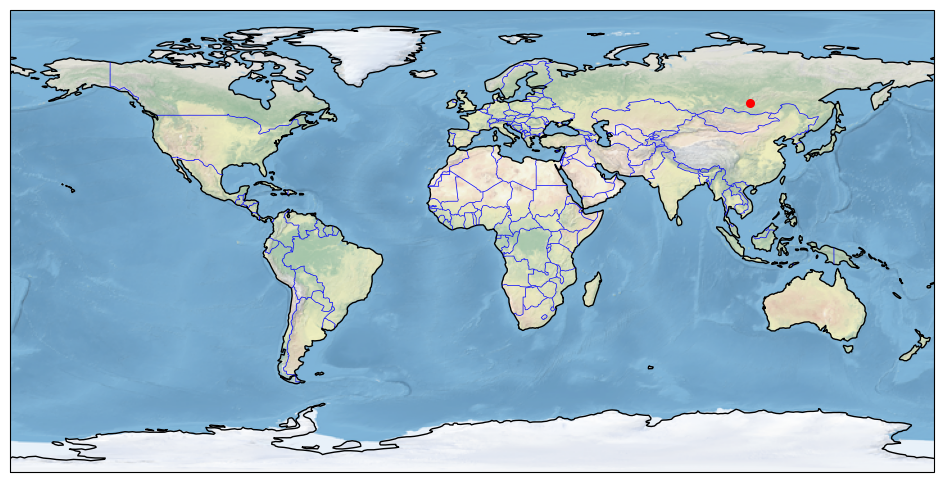

In [7]:
fig = plt.figure(figsize = (12,6))
ax = plt.subplot(1,1,1, projection = crs.PlateCarree())

ax.coastlines()
ax.add_feature(feature.BORDERS, linewidth=0.5, edgecolor='blue')
ax.stock_img()

# add lake location 
lat = float(xr_lake.lake_barycentre_latitude.split()[0])
if 'S' in xr_lake.lake_barycentre_latitude:
    lat = -lat
lon = float(xr_lake.lake_barycentre_longitude.split()[0])
if 'W' in xr_lake.lake_barycentre_longitude:
    lon = -lon
    
print (f"Lake location (lat, lon): {lat}°, {lon}°")
plt.scatter(x = [lon], y = [lat], s = 30, color = 'red', transform = crs.PlateCarree())

 # 3. Visualise lake water level time series

Now that the data has been extracted, we can read it and plot it. To read the data in NetCDF format we use the Xarray library and for the visualisation of the time series we use Matplotlib

The figure with the timeseries will be saved in the output directory in png format:
[lake_name]_timeseries.png file

The change in time step due to coverage by multiple missions can be seen in the figure: in recent years, Lake Baikal has been monitored by multiple missions and trajectories. As a result, the temporal resolution increases (the time between observations is reduced) and the time series is noisier due to the effect of the inter-mission and inter-tracks bias. 

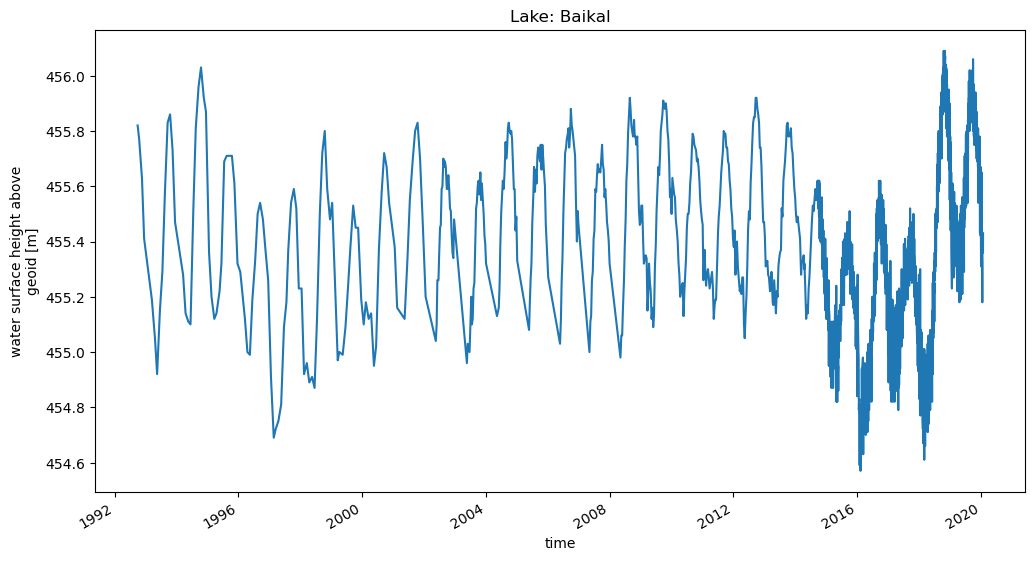

In [8]:
# plot and visualise the timeseries
fig = plt.figure(figsize = (12, 6))
xr_lake.water_surface_height_above_reference_datum.plot()
plt.title(f'Lake: {lake_name.title()}')

# save the figure
png_file = f'{output_dir}/{lake_name}_timeseries.png'
plt.savefig(png_file, dpi=300, bbox_inches="tight")

 # 3. Visualise lake water level yearly anomalies
 
Another way of analysing variations in water levels is to visualise anomalies in relation to average values over a reference period in the form of a bar chart, using red and blue colours to easily identify the year when levels are higher or lower than the climatic normal.

The same code can be used for the visualiation of yearly anomalies compared to a particular year. 


The reference period can be adapted to each lake. Indeed, the temporal coverage is not the same for all the lakes in the CDS, with the first available date ranging from 1992, as is the case for Lake Baikal, to 2019 for lakes monitored exclusively by the Sentinel-3B mission. In this example for Lake Baikal, we have chosen a reference period consisting of the first 10 years of data.

In [9]:
first_reference_year = 1992
last_reference_year  = 2002

The yearly anomaly is calculated by first applying xarray's groupby() function to group the data by year and then calculating the mean value for each annual group. The average value of the water in the reference lake is estimated as the average water level over the reference period.

In [10]:
yearly_mean = xr_lake.groupby('time.year').mean(keep_attrs = True)

ref = yearly_mean.where((yearly_mean.year >= first_reference_year ) & (yearly_mean.year <= last_reference_year ))
ref_lwl_mean = np.nanmean(ref.water_surface_height_above_reference_datum.values)

print (f'Mean LWL value during the reference period: {np.round(ref_lwl_mean,3)} (m)')

Mean LWL value during the reference period: 455.386 (m)


The yearly anomaly is shown in red for values above the average water level during the reference period and in blue for values below.

The figure with the anomalies is saved in the output directory in png format :
[lake_name]_yearly-anomalies.png file

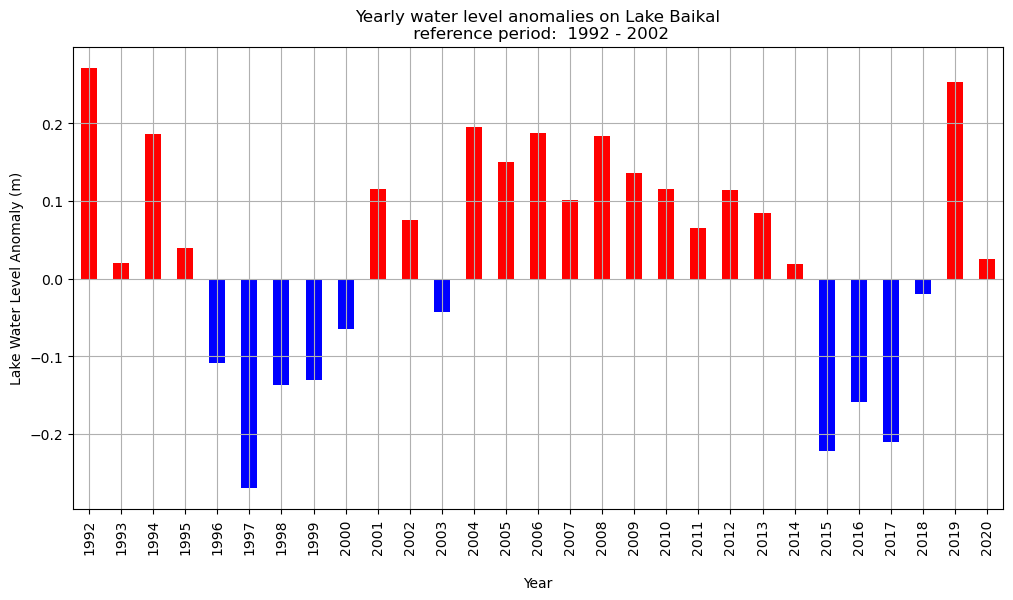

In [11]:
year_mean = yearly_mean.to_dataframe()
year_mean['lwl_yearly_anomaly'] = year_mean['water_surface_height_above_reference_datum'] - ref_lwl_mean
year_mean['positive_anomaly'] = year_mean['lwl_yearly_anomaly'] > 0

fig, ax = plt.subplots(figsize=(12, 6))
year_mean['lwl_yearly_anomaly'].plot(kind='bar', 
                                     color = year_mean.positive_anomaly.map ({True: 'red', False: 'blue'}),
                                     xlabel = '\nYear',
                                     ylabel = 'Lake Water Level Anomaly (m)',
                                     title = f'Yearly water level anomalies on Lake {lake_name.title()}\n reference period:  {first_reference_year} - {last_reference_year}')

ax.grid()

# save the figure
png_file = f'{output_dir}/{lake_name}_yearly-anomalies.png'
plt.savefig(png_file, dpi=300, bbox_inches='tight')